In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score
from scipy.ndimage.filters import gaussian_filter1d, uniform_filter1d, median_filter
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style("darkgrid")

#Import libraries for Deep Learning
from keras.models import Sequential, Model
from keras.layers import Conv1D, LSTM, MaxPool1D, Dense,Dropout, Flatten, BatchNormalization,Input, concatenate,Activation, merge
from keras.optimizers import Adam


print ('Libraries Loaded!')

Using TensorFlow backend.


Libraries Loaded!


In [2]:
#Created a function to remove noise from data with fourier transformation

def fourier(data):
    datafft= np.zeros(data.shape)
    for row in range(data.shape[0]):
        #fft
        fou=np.fft.fft(data[row])
        f1,f2= 0, 0
        fr=np.fft.fftfreq(3197,0.01)
        #make up a narrow bandpass with a Gaussian
        df=0.1
        gpl= np.exp(- ((fr-f1)/(2*df))**2)+ np.exp(- ((fr-f2)/(2*df))**2)  # pos. frequencies
        gmn= np.exp(- ((fr+f1)/(2*df))**2)+ np.exp(- ((fr+f2)/(2*df))**2)  # neg. frequencies
        g=gpl+gmn    
        filt=fou*g  #filtered spectrum = spectrum * bandpass 
        #ifft
        s2=np.fft.ifft(filt)
        datafft[row]= s2
    return (datafft)

# Load Dataset
The data is Loaded and the LABELS is converted from (1,2) to (0,1) for conviniency.

In [3]:
data1 = pd.read_csv('ExoTrain.csv')
Y1 = data1['LABEL'].values - 1
X = data1.drop('LABEL', axis=1).values
Y = Y1[:,np.newaxis]

# Data Visualisation

Label= 1 
First Column-      Original
Second Column-     Rolling Mean
Third Column-      Median Filter
Fourth Column-     Uniform Filter
Fifth Column-      Fourier Filter 


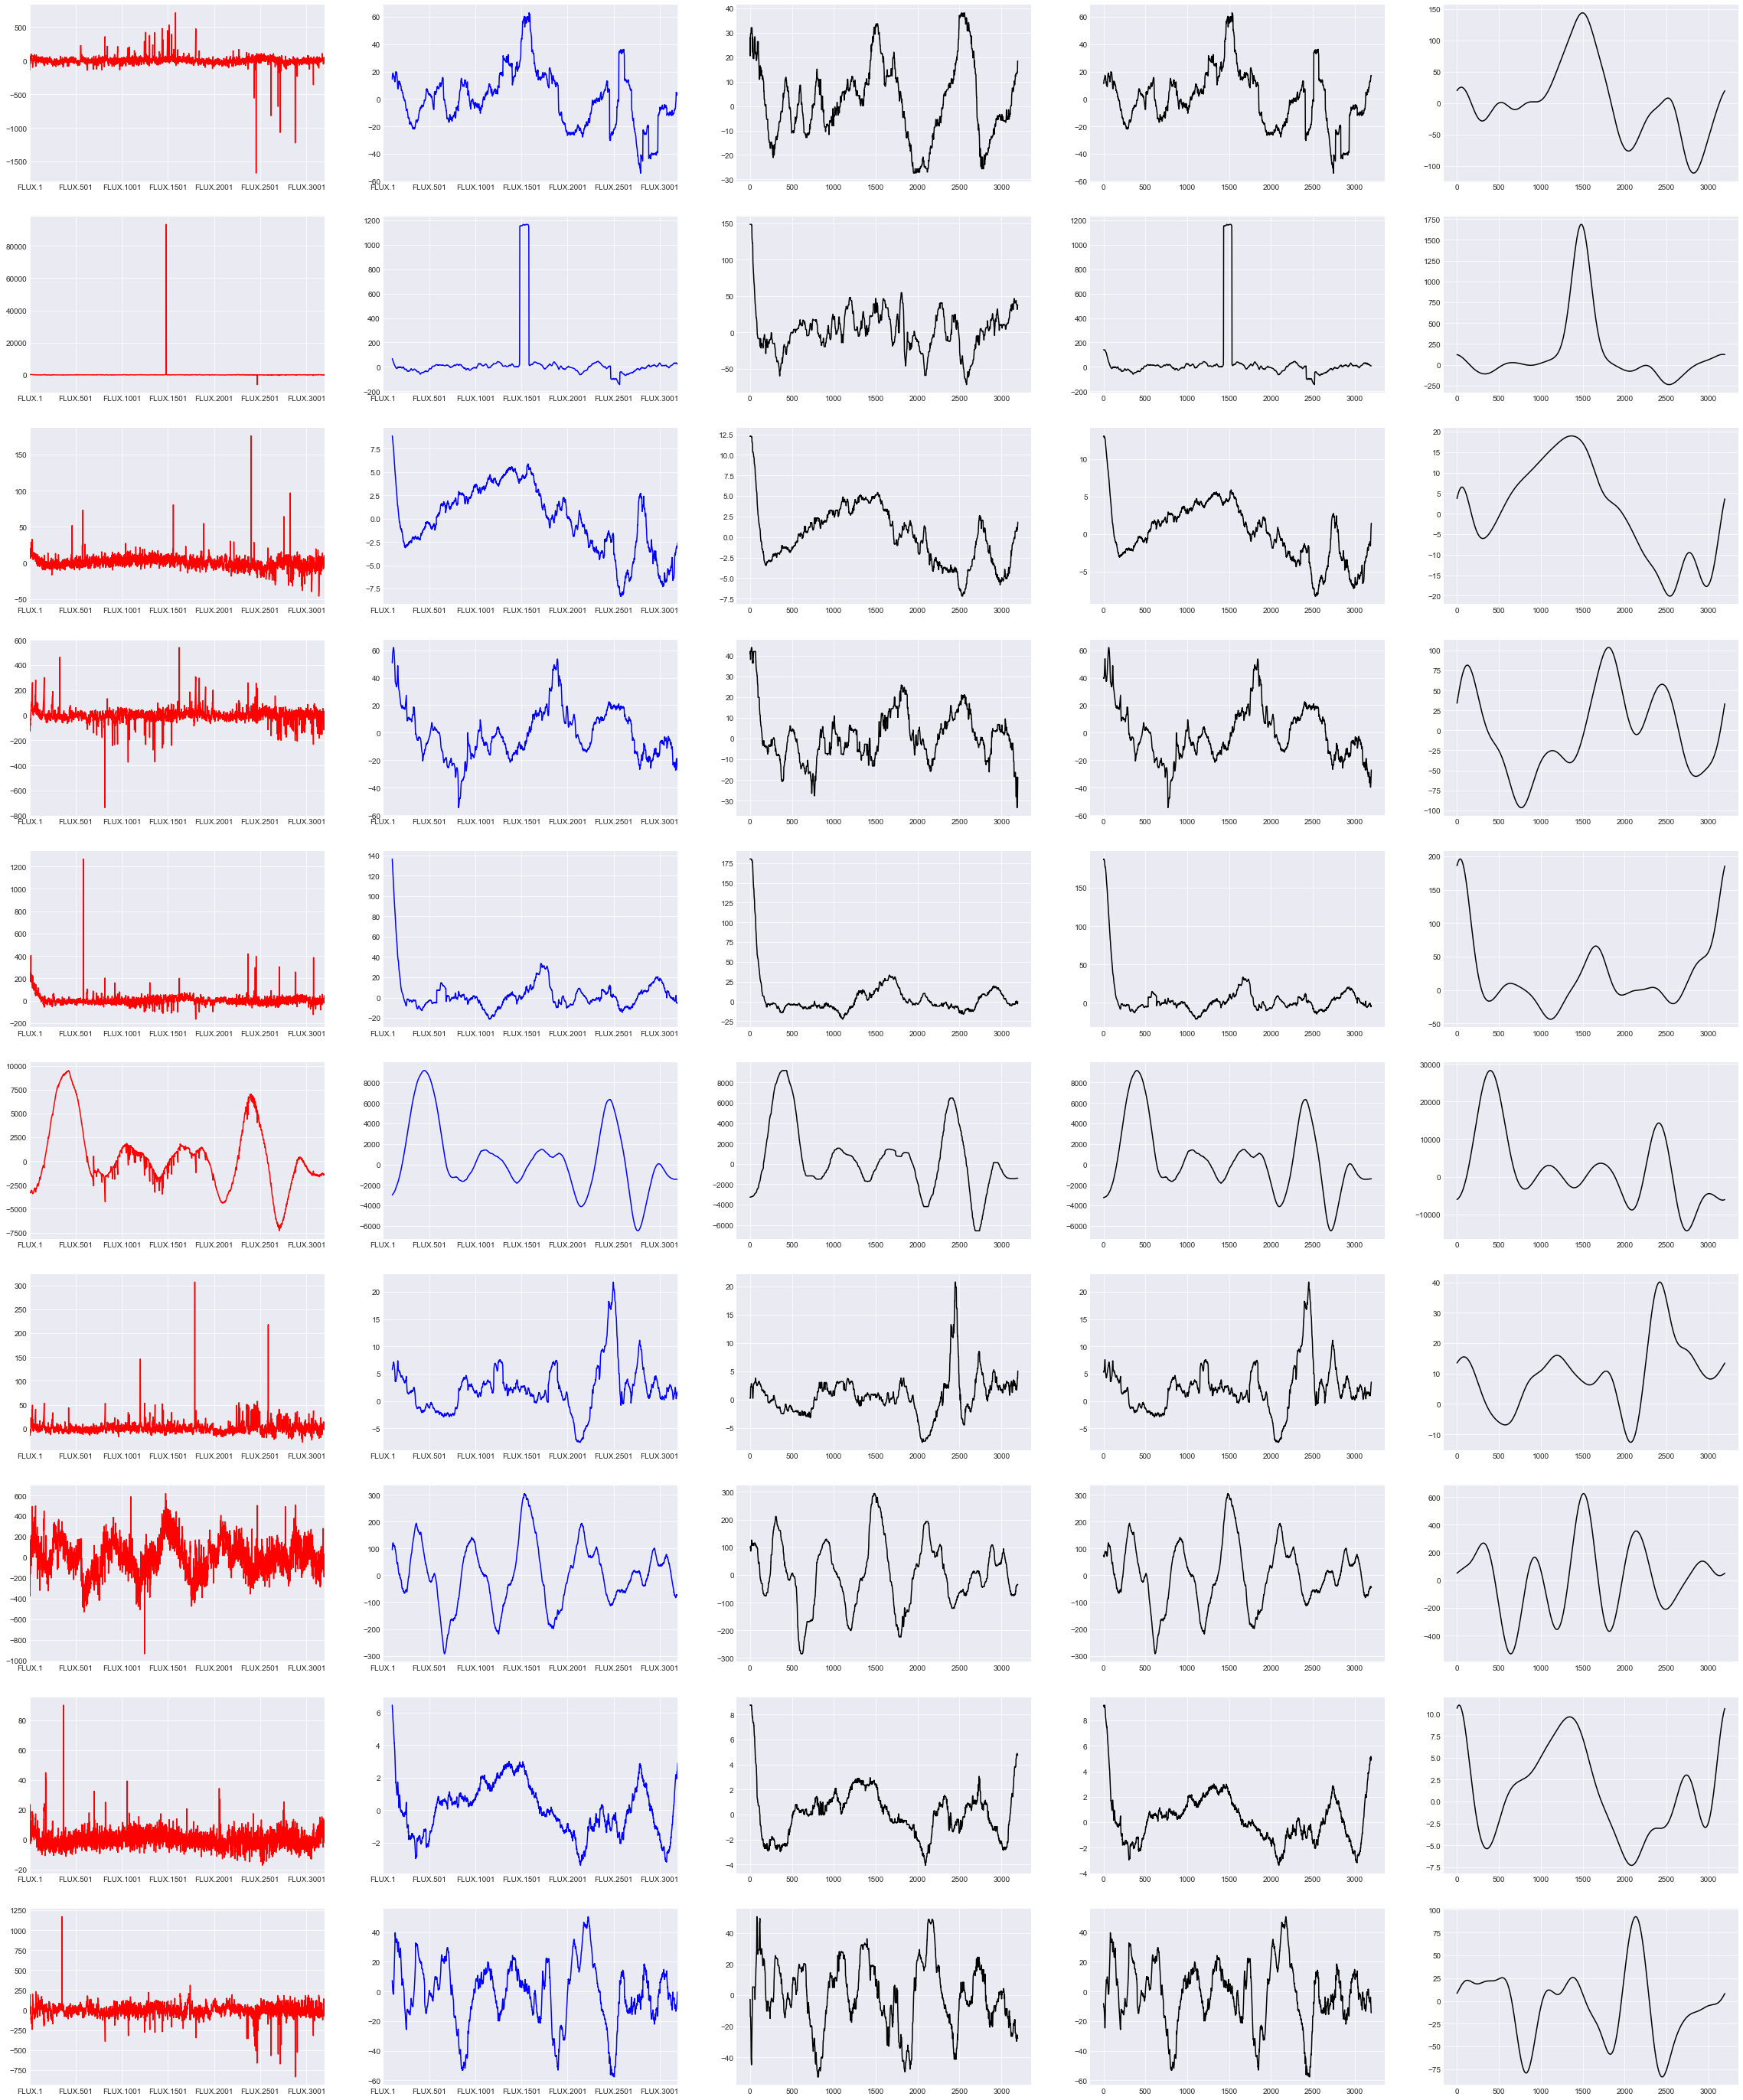

In [4]:
label= 1             # Here label i is exoplanet and 0 is non-planet
num_row=10           # Number of rows to plot
col_plot=5           # 5 plots in a row
j=1
train= data1          # plots from training data

print ('Label=', label,'\n\
First Column-      Original\n\
Second Column-     Rolling Mean\n\
Third Column-      Median Filter\n\
Fourth Column-     Uniform Filter\n\
Fifth Column-      Fourier Filter ')
fig = plt.figure(figsize=(8*col_plot, num_row*5))
for i in range(num_row):
    
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new1= train[train.LABEL==label].iloc[i, :].drop('LABEL')
    new1.plot(color= 'red', label= 'new1')
   
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new2= pd.rolling_mean( train[train.LABEL==label].iloc[i, :].drop('LABEL'), window= 100)
    new2.plot(color= 'blue', label= 'new2')
   
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new3=median_filter(train[train.LABEL==label].iloc[i, :].drop('LABEL'), size=100)
    plt.plot(new3, color= 'black', label= 'new3')
    
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new4= uniform_filter1d(train[train.LABEL==label].iloc[i, :].drop('LABEL'), size=100)
    plt.plot(new4, color= 'black', label= 'new4')
    
    fig.add_subplot(num_row,col_plot,j); j=j+1
    new5= fourier(train[train.LABEL==label].iloc[i, :].drop('LABEL').values[np.newaxis, :])
    plt.plot(new5[0], color= 'black', label= 'new5')


# Split data for training and testing

In [5]:
# simple cross-validation.(k-fold cross validation not used because of lot of time being taken for training k*timenow)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=531, stratify=Y)

# Data preprocessing 

In [6]:
#Scale each observation to zero mean and unit variance.
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [7]:
#Noise in the data can be ignored by adding a gaussian filter
#This could more elegantly be done as an extra layer with fixed weights.
x_train1 = np.stack([x_train, gaussian_filter1d(x_train, 1, axis=1)], axis=2)
x_test1 = np.stack([x_test, gaussian_filter1d(x_test, 1, axis=1)], axis=2)

In [8]:
x_train2 = np.stack([x_train, fourier(x_train)], axis=2)
x_test2 = np.stack([x_test, fourier(x_test)], axis=2)

In [9]:
x_train3 = x_train[:,:,np.newaxis]
x_test3 = x_test[:,:,np.newaxis]

In [10]:
print ('Shape of x_train1', x_train1.shape)
print ('Shape of x_test1', x_test1.shape)
print("*"*40)
print ('Shape of x_train2', x_train2.shape)
print ('Shape of x_test2', x_test2.shape)
print("*"*40)
print ('Shape of x_train3', x_train3.shape)
print ('Shape of x_test3', x_test3.shape)

Shape of x_train1 (3564, 3197, 2)
Shape of x_test1 (396, 3197, 2)
****************************************
Shape of x_train2 (3564, 3197, 2)
Shape of x_test2 (396, 3197, 2)
****************************************
Shape of x_train3 (3564, 3197, 1)
Shape of x_test3 (396, 3197, 1)


# Model Architecture

In [11]:
# 1-D convolutions are frequently used to learn sequential patterns
model1 = Sequential()
model1.add(Conv1D(filters=16, kernel_size=11, activation='relu', input_shape=x_train1.shape[1:]))
model1.add(MaxPool1D(strides=4))
model1.add(BatchNormalization())
model1.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model1.add(MaxPool1D(strides=4))
model1.add(BatchNormalization())
model1.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model1.add(MaxPool1D(strides=4))
model1.add(BatchNormalization())
model1.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model1.add(MaxPool1D(strides=4))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))

In [12]:
# 1-D convolutions are frequently used to learn sequential patterns
model2 = Sequential()
model2.add(Conv1D(filters=24, kernel_size=11, activation='relu', input_shape=x_train2.shape[1:]))
model2.add(MaxPool1D(strides=4))
model2.add(BatchNormalization())
model2.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model2.add(MaxPool1D(strides=4))
model2.add(BatchNormalization())
model2.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model2.add(MaxPool1D(strides=4))
model2.add(BatchNormalization())
model2.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model2.add(MaxPool1D(strides=4))
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))

In [13]:
model3 = Sequential()
model3.add(Conv1D(filters=16, kernel_size=11, activation='relu', input_shape=x_train3.shape[1:]))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model3.add(MaxPool1D(strides=4))
model3.add(LSTM(10))
model3.add(Dense(1, activation='sigmoid'))

In [14]:
x_input= Input(shape= x_train1.shape[1:])
x= Conv1D(filters=1, kernel_size=11, activation='relu', padding='same')(x_input)
x=BatchNormalization()(x)

m=merge([x, x_input], mode= 'concat')

x= Conv1D(filters=16, kernel_size=11, activation='relu')(m)
x=MaxPool1D(strides=4)(x)
x=BatchNormalization()(x)

x= Conv1D(filters=16, kernel_size=11, activation='relu')(x)
x=MaxPool1D(strides=4)(x)
x=BatchNormalization()(x)

x= Conv1D(filters=64, kernel_size=11, activation='relu')(x)
x= MaxPool1D(strides=4)(x)
x=Flatten()(x)
x=Dropout(.3)(x)
x=Dense(32, activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(64, activation='relu')(x)
x=Dense(1, activation='sigmoid')(x)
model4= Model(input=x_input, output= x)

model4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [15]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3187, 16)          368       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 797, 16)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 797, 16)           64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 787, 64)           11328     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 197, 64)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 197, 64)           256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 187, 32)           22560     
__________

In [16]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 3187, 24)          552       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 797, 24)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 797, 24)           96        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 791, 64)           10816     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 198, 64)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 198, 64)           256       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 188, 64)           45120     
__________

In [17]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 3187, 16)          192       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 797, 16)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 797, 16)           64        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 787, 64)           11328     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 197, 64)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 197, 64)           256       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 187, 32)           22560     
__________

In [18]:
model4.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3197, 2)       0                                            
____________________________________________________________________________________________________
conv1d_13 (Conv1D)               (None, 3197, 1)       23          input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_10 (BatchNor (None, 3197, 1)       4           conv1d_13[0][0]                  
____________________________________________________________________________________________________
merge_1 (Merge)                  (None, 3197, 3)       0           batch_normalization_10[0][0]     
                                                                   input_1[0][0]           

# Data Augmentation

In [19]:
# feeding training data to the model in batches
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = 16
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    planet = np.where(y_train[:,0] == 1.)[0]
    non_planet = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(planet)
        np.random.shuffle(non_planet)
    
        x_batch[:half_batch] = x_train[planet[:half_batch]]
        x_batch[half_batch:] = x_train[non_planet[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[planet[:half_batch]]
        y_batch[half_batch:] = y_train[non_planet[half_batch:batch_size]]
    
        for i in range(batch_size):
            roll_state = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], roll_state, axis = 0)
     
        yield x_batch, y_batch

# Training the models

In [20]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_history = model1.fit_generator(batch_generator(x_train1, y_train, 48),
                    validation_data=(x_test1, y_test),
                    verbose=2, epochs=35,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/35
35s - loss: 0.6334 - acc: 0.6380 - val_loss: 0.3761 - val_acc: 0.9924
Epoch 2/35
34s - loss: 0.4290 - acc: 0.7816 - val_loss: 0.2317 - val_acc: 0.8965
Epoch 3/35
35s - loss: 0.2209 - acc: 0.9144 - val_loss: 0.1486 - val_acc: 0.9242
Epoch 4/35
35s - loss: 0.1597 - acc: 0.9434 - val_loss: 0.1060 - val_acc: 0.9419
Epoch 5/35
35s - loss: 0.0976 - acc: 0.9693 - val_loss: 0.0473 - val_acc: 0.9798
Epoch 6/35
35s - loss: 0.0878 - acc: 0.9726 - val_loss: 0.2558 - val_acc: 0.8990
Epoch 7/35
34s - loss: 0.0594 - acc: 0.9815 - val_loss: 0.0156 - val_acc: 0.9949
Epoch 8/35
34s - loss: 0.0491 - acc: 0.9867 - val_loss: 0.0450 - val_acc: 0.9823
Epoch 9/35
34s - loss: 0.0434 - acc: 0.9867 - val_loss: 0.0097 - val_acc: 0.9949
Epoch 10/35
34s - loss: 0.0589 - acc: 0.9838 - val_loss: 0.0236 - val_acc: 0.9899
Epoch 11/35
35s - loss: 0.0270 - acc: 0.9922 - val_loss: 0.0264 - val_acc: 0.9874
Epoch 12/35
34s - loss: 0.0268 - acc: 0.9941 - val_loss: 0.0367 - val_acc: 0.9899
Epoch 13/35
35s - loss: 0

In [21]:
model1.compile(optimizer=Adam(0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
model1_history2 = model1.fit_generator(batch_generator(x_train1, y_train, 48), 
                           validation_data=(x_test1, y_test), 
                           verbose=2, epochs=10,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
35s - loss: 0.0076 - acc: 0.9981 - val_loss: 0.0102 - val_acc: 0.9975
Epoch 2/10
34s - loss: 0.0030 - acc: 0.9989 - val_loss: 0.0106 - val_acc: 0.9975
Epoch 3/10
34s - loss: 0.0063 - acc: 0.9979 - val_loss: 0.0098 - val_acc: 0.9975
Epoch 4/10
34s - loss: 0.0043 - acc: 0.9998 - val_loss: 0.0100 - val_acc: 0.9975
Epoch 5/10
34s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0108 - val_acc: 0.9975
Epoch 6/10
34s - loss: 0.0085 - acc: 0.9992 - val_loss: 0.0105 - val_acc: 0.9975
Epoch 7/10
34s - loss: 0.0063 - acc: 0.9989 - val_loss: 0.0103 - val_acc: 0.9975
Epoch 8/10
34s - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0124 - val_acc: 0.9975
Epoch 9/10
34s - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0095 - val_acc: 0.9975
Epoch 10/10
34s - loss: 0.0092 - acc: 0.9992 - val_loss: 0.0115 - val_acc: 0.9949


In [22]:
model1.compile(optimizer=Adam(0.00001), loss = 'binary_crossentropy', metrics=['accuracy'])
model1_history3 = model1.fit_generator(batch_generator(x_train1, y_train, 48), 
                    validation_data=(x_test1, y_test),
                    verbose=2, epochs=10,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
36s - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0107 - val_acc: 0.9949
Epoch 2/10
34s - loss: 0.0106 - acc: 0.9987 - val_loss: 0.0117 - val_acc: 0.9949
Epoch 3/10
34s - loss: 0.0056 - acc: 0.9992 - val_loss: 0.0120 - val_acc: 0.9949
Epoch 4/10
35s - loss: 0.0029 - acc: 0.9989 - val_loss: 0.0114 - val_acc: 0.9949
Epoch 5/10
34s - loss: 0.0108 - acc: 0.9994 - val_loss: 0.0115 - val_acc: 0.9949
Epoch 6/10
34s - loss: 0.0092 - acc: 0.9987 - val_loss: 0.0116 - val_acc: 0.9949
Epoch 7/10
34s - loss: 0.0044 - acc: 0.9994 - val_loss: 0.0113 - val_acc: 0.9949
Epoch 8/10
34s - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0105 - val_acc: 0.9949
Epoch 9/10
34s - loss: 0.0044 - acc: 0.9994 - val_loss: 0.0102 - val_acc: 0.9949
Epoch 10/10
34s - loss: 0.0100 - acc: 0.9992 - val_loss: 0.0103 - val_acc: 0.9949


In [23]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_history = model2.fit_generator(batch_generator(x_train2, y_train, 48), 
                    validation_data=(x_test2, y_test),
                    verbose=2, epochs=35,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/35
44s - loss: 0.5336 - acc: 0.7275 - val_loss: 0.2147 - val_acc: 0.9646
Epoch 2/35
43s - loss: 0.3236 - acc: 0.8548 - val_loss: 0.4409 - val_acc: 0.7424
Epoch 3/35
43s - loss: 0.2370 - acc: 0.9032 - val_loss: 0.4905 - val_acc: 0.6793
Epoch 4/35
43s - loss: 0.1747 - acc: 0.9358 - val_loss: 0.1437 - val_acc: 0.9444
Epoch 5/35
43s - loss: 0.1253 - acc: 0.9543 - val_loss: 0.1167 - val_acc: 0.9444
Epoch 6/35
44s - loss: 0.1003 - acc: 0.9634 - val_loss: 0.0942 - val_acc: 0.9571
Epoch 7/35
43s - loss: 0.0894 - acc: 0.9695 - val_loss: 0.1476 - val_acc: 0.9419
Epoch 8/35
43s - loss: 0.0594 - acc: 0.9792 - val_loss: 0.0783 - val_acc: 0.9798
Epoch 9/35
44s - loss: 0.0366 - acc: 0.9878 - val_loss: 0.0653 - val_acc: 0.9823
Epoch 10/35
43s - loss: 0.0345 - acc: 0.9888 - val_loss: 0.0752 - val_acc: 0.9874
Epoch 11/35
43s - loss: 0.0267 - acc: 0.9926 - val_loss: 0.0378 - val_acc: 0.9924
Epoch 12/35
43s - loss: 0.0241 - acc: 0.9918 - val_loss: 0.0575 - val_acc: 0.9874
Epoch 13/35
43s - loss: 0

In [24]:
model2.compile(optimizer=Adam(0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
model2_history2 = model2.fit_generator(batch_generator(x_train2, y_train, 48), 
                           validation_data=(x_test2, y_test), 
                           verbose=2, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
44s - loss: 0.0084 - acc: 0.9983 - val_loss: 0.0825 - val_acc: 0.9949
Epoch 2/5
43s - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0818 - val_acc: 0.9949
Epoch 3/5
43s - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0810 - val_acc: 0.9949
Epoch 4/5
44s - loss: 0.0030 - acc: 0.9989 - val_loss: 0.0810 - val_acc: 0.9949
Epoch 5/5
43s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0810 - val_acc: 0.9949


In [25]:
model2.compile(optimizer=Adam(0.00001), loss = 'binary_crossentropy', metrics=['accuracy'])
model2_history3 = model2.fit_generator(batch_generator(x_train2, y_train, 48), 
                    validation_data=(x_test2, y_test),
                    verbose=2, epochs=5,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
45s - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0810 - val_acc: 0.9949
Epoch 2/5
43s - loss: 0.0040 - acc: 0.9989 - val_loss: 0.0810 - val_acc: 0.9949
Epoch 3/5
43s - loss: 0.0092 - acc: 0.9983 - val_loss: 0.0810 - val_acc: 0.9949
Epoch 4/5
43s - loss: 0.0012 - acc: 0.9994 - val_loss: 0.0810 - val_acc: 0.9949
Epoch 5/5
43s - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0810 - val_acc: 0.9949


In [26]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_history = model3.fit_generator(batch_generator(x_train3, y_train, 48), 
                    validation_data=(x_test3, y_test),
                    verbose=2, epochs=35,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/35
35s - loss: 0.4287 - acc: 0.8260 - val_loss: 0.2525 - val_acc: 0.9924
Epoch 2/35
33s - loss: 0.1915 - acc: 0.9348 - val_loss: 0.0511 - val_acc: 0.9848
Epoch 3/35
33s - loss: 0.1124 - acc: 0.9657 - val_loss: 0.0476 - val_acc: 0.9899
Epoch 4/35
33s - loss: 0.0802 - acc: 0.9756 - val_loss: 0.0955 - val_acc: 0.9672
Epoch 5/35
33s - loss: 0.0506 - acc: 0.9855 - val_loss: 0.0697 - val_acc: 0.9722
Epoch 6/35
33s - loss: 0.0401 - acc: 0.9891 - val_loss: 0.0424 - val_acc: 0.9848
Epoch 7/35
33s - loss: 0.0291 - acc: 0.9926 - val_loss: 0.0241 - val_acc: 0.9924
Epoch 8/35
33s - loss: 0.0366 - acc: 0.9884 - val_loss: 0.0384 - val_acc: 0.9848
Epoch 9/35
33s - loss: 0.0149 - acc: 0.9960 - val_loss: 0.0134 - val_acc: 0.9924
Epoch 10/35
33s - loss: 0.0186 - acc: 0.9949 - val_loss: 0.0350 - val_acc: 0.9899
Epoch 11/35
33s - loss: 0.0220 - acc: 0.9937 - val_loss: 0.0172 - val_acc: 0.9949
Epoch 12/35
33s - loss: 0.0161 - acc: 0.9954 - val_loss: 0.0284 - val_acc: 0.9899
Epoch 13/35
33s - loss: 0

In [27]:
model3.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model3_history2 = model3.fit_generator(batch_generator(x_train3, y_train, 48), 
                    validation_data=(x_test3, y_test),
                    verbose=2, epochs=10,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
34s - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0142 - val_acc: 0.9975
Epoch 2/10
33s - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0139 - val_acc: 0.9975
Epoch 3/10
33s - loss: 0.0049 - acc: 0.9989 - val_loss: 0.0142 - val_acc: 0.9975
Epoch 4/10
33s - loss: 0.0059 - acc: 0.9992 - val_loss: 0.0199 - val_acc: 0.9949
Epoch 5/10
33s - loss: 0.0043 - acc: 0.9989 - val_loss: 0.0169 - val_acc: 0.9975
Epoch 6/10
33s - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0206 - val_acc: 0.9949
Epoch 7/10
33s - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0209 - val_acc: 0.9924
Epoch 8/10
33s - loss: 0.0040 - acc: 0.9992 - val_loss: 0.0158 - val_acc: 0.9975
Epoch 9/10
33s - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0162 - val_acc: 0.9975
Epoch 10/10
33s - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0158 - val_acc: 0.9975


In [28]:
model3.compile(loss='binary_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])
model3_history3 = model3.fit_generator(batch_generator(x_train3, y_train, 32), 
                    validation_data=(x_test3, y_test),
                    verbose=2, epochs=5,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
24s - loss: 0.0245 - acc: 0.9931 - val_loss: 0.0152 - val_acc: 0.9975
Epoch 2/5
23s - loss: 0.0200 - acc: 0.9927 - val_loss: 0.0149 - val_acc: 0.9975
Epoch 3/5
23s - loss: 0.0123 - acc: 0.9972 - val_loss: 0.0150 - val_acc: 0.9975
Epoch 4/5
23s - loss: 0.0087 - acc: 0.9981 - val_loss: 0.0149 - val_acc: 0.9975
Epoch 5/5
23s - loss: 0.0060 - acc: 0.9981 - val_loss: 0.0145 - val_acc: 0.9975


In [29]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4_history = model4.fit_generator(batch_generator(x_train1, y_train, 48), 
                    validation_data=(x_test1, y_test),
                    verbose=2, epochs=35,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/35
28s - loss: 0.5499 - acc: 0.7153 - val_loss: 0.6013 - val_acc: 0.6313
Epoch 2/35
26s - loss: 0.2879 - acc: 0.8683 - val_loss: 0.2097 - val_acc: 0.8586
Epoch 3/35
26s - loss: 0.1528 - acc: 0.9377 - val_loss: 0.0534 - val_acc: 0.9798
Epoch 4/35
26s - loss: 0.1171 - acc: 0.9554 - val_loss: 0.0257 - val_acc: 0.9949
Epoch 5/35
26s - loss: 0.1018 - acc: 0.9625 - val_loss: 0.0426 - val_acc: 0.9848
Epoch 6/35
26s - loss: 0.0796 - acc: 0.9729 - val_loss: 0.0266 - val_acc: 0.9874
Epoch 7/35
26s - loss: 0.0735 - acc: 0.9760 - val_loss: 0.0663 - val_acc: 0.9722
Epoch 8/35
26s - loss: 0.0637 - acc: 0.9802 - val_loss: 0.0234 - val_acc: 0.9924
Epoch 9/35
26s - loss: 0.0643 - acc: 0.9802 - val_loss: 0.0228 - val_acc: 0.9924
Epoch 10/35
26s - loss: 0.0547 - acc: 0.9813 - val_loss: 0.0979 - val_acc: 0.9571
Epoch 11/35
26s - loss: 0.0513 - acc: 0.9813 - val_loss: 0.0295 - val_acc: 0.9874
Epoch 12/35
27s - loss: 0.0472 - acc: 0.9832 - val_loss: 0.0680 - val_acc: 0.9672
Epoch 13/35
26s - loss: 0

In [30]:
model4.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model4_history2 = model4.fit_generator(batch_generator(x_train1, y_train, 48), 
                    validation_data=(x_test1, y_test),
                    verbose=2, epochs=10,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/10
28s - loss: 0.0156 - acc: 0.9975 - val_loss: 0.0050 - val_acc: 0.9975
Epoch 2/10
26s - loss: 0.0057 - acc: 0.9981 - val_loss: 0.0042 - val_acc: 0.9975
Epoch 3/10
26s - loss: 0.0036 - acc: 0.9992 - val_loss: 0.0040 - val_acc: 0.9975
Epoch 4/10
26s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0054 - val_acc: 0.9975
Epoch 5/10
26s - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0036 - val_acc: 0.9975
Epoch 6/10
26s - loss: 0.0074 - acc: 0.9987 - val_loss: 0.0026 - val_acc: 0.9975
Epoch 7/10
27s - loss: 0.0041 - acc: 0.9994 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 8/10
27s - loss: 0.0090 - acc: 0.9981 - val_loss: 0.0063 - val_acc: 0.9975
Epoch 9/10
26s - loss: 0.0052 - acc: 0.9987 - val_loss: 0.0034 - val_acc: 0.9975
Epoch 10/10
26s - loss: 0.0042 - acc: 0.9989 - val_loss: 0.0024 - val_acc: 0.9975


In [31]:
model4.compile(loss='binary_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])
model4_history3 = model4.fit_generator(batch_generator(x_train1, y_train, 48), 
                    validation_data=(x_test1, y_test),
                    verbose=2, epochs=5,
                    steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
28s - loss: 0.0069 - acc: 0.9983 - val_loss: 0.0027 - val_acc: 0.9975
Epoch 2/5
26s - loss: 0.0106 - acc: 0.9979 - val_loss: 0.0027 - val_acc: 0.9975
Epoch 3/5
26s - loss: 0.0040 - acc: 0.9987 - val_loss: 0.0027 - val_acc: 0.9975
Epoch 4/5
26s - loss: 0.0080 - acc: 0.9985 - val_loss: 0.0025 - val_acc: 0.9975
Epoch 5/5
26s - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0019 - val_acc: 1.0000


# Results Visulalisation

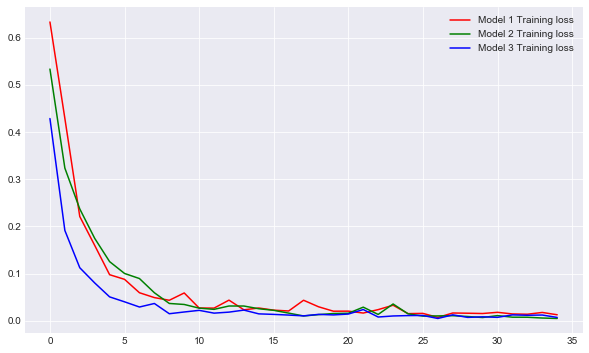

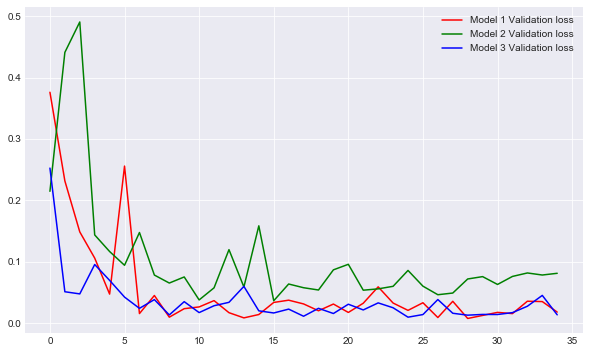

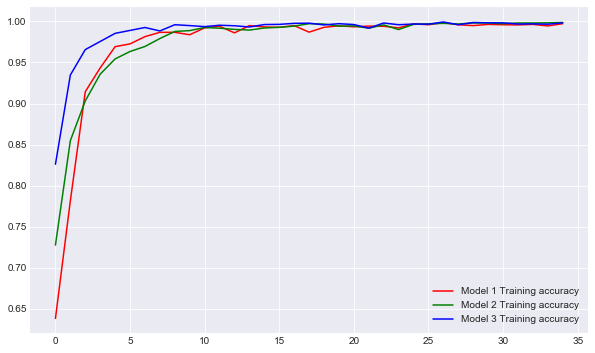

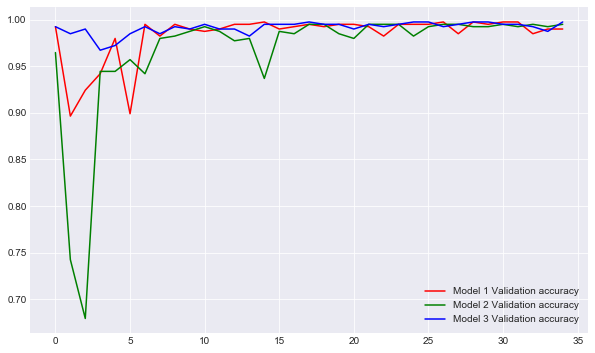

In [32]:
# plotting validation loss and accuracy
plt.figure(figsize=(10,6))
plt.plot(model1_history.history['loss'], color='r', label="Model 1 Training loss")
plt.plot(model2_history.history['loss'], color='g', label="Model 2 Training loss")
plt.plot(model3_history.history['loss'], color='b', label="Model 3 Training loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model1_history.history['val_loss'], color='r', label="Model 1 Validation loss")
plt.plot(model2_history.history['val_loss'], color='g', label="Model 2 Validation loss")
plt.plot(model3_history.history['val_loss'], color='b', label="Model 3 Validation loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model1_history.history['acc'], color='r', label="Model 1 Training accuracy")
plt.plot(model2_history.history['acc'], color='g', label="Model 2 Training accuracy")
plt.plot(model3_history.history['acc'], color='b', label="Model 3 Training accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model1_history.history['val_acc'], color='r', label="Model 1 Validation accuracy")
plt.plot(model2_history.history['val_acc'], color='g', label="Model 2 Validation accuracy")
plt.plot(model3_history.history['val_acc'], color='b', label="Model 3 Validation accuracy")
plt.legend()
plt.show()


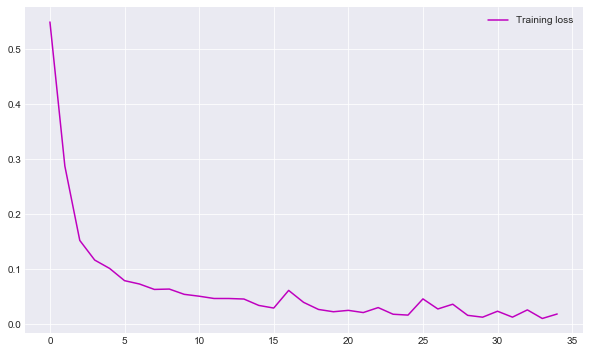

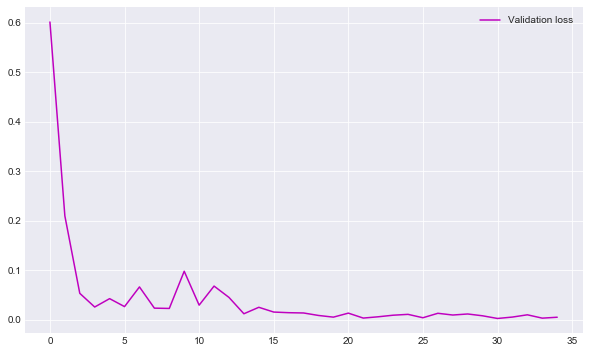

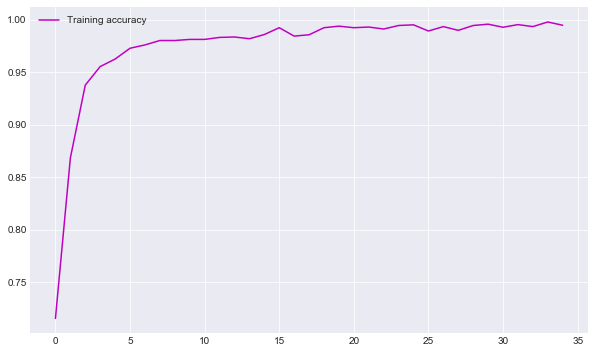

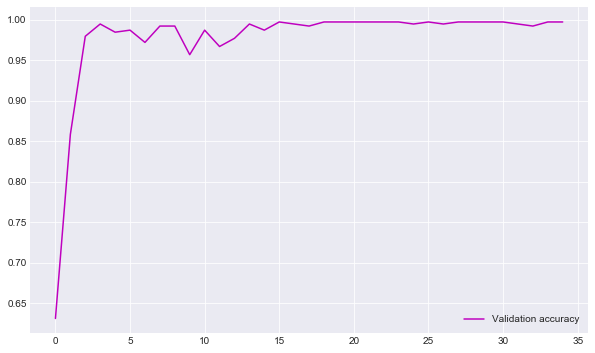

In [33]:
plt.figure(figsize=(10,6))
plt.plot(model4_history.history['loss'], color='m', label="Training loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model4_history.history['val_loss'], color='m', label="Validation loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model4_history.history['acc'], color='m', label="Training accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(model4_history.history['val_acc'], color='m', label="Validation accuracy")
plt.legend()
plt.show()


In [34]:
# obtaining the indexes of yes-exoplanet and no-exoplanet
no_exoplanet = np.where(y_test[:,0] == 0.)[0]
yes_exoplanet = np.where(y_test[:,0] == 1.)[0]

In [35]:
y_pred1 = model1.predict(x_test1)[:,0]

y_pred2 = model2.predict(x_test2)[:,0]

y_pred3 = model3.predict(x_test3)[:,0]

y_pred4 = model4.predict(x_test1)[:,0]

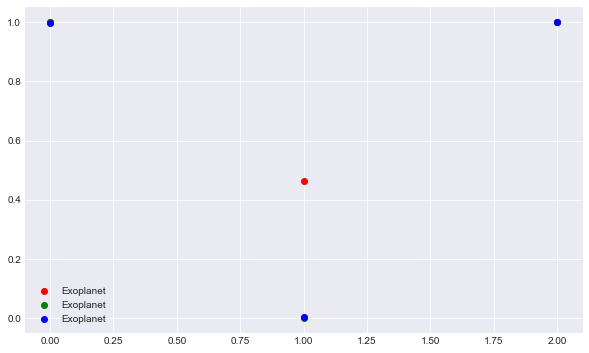

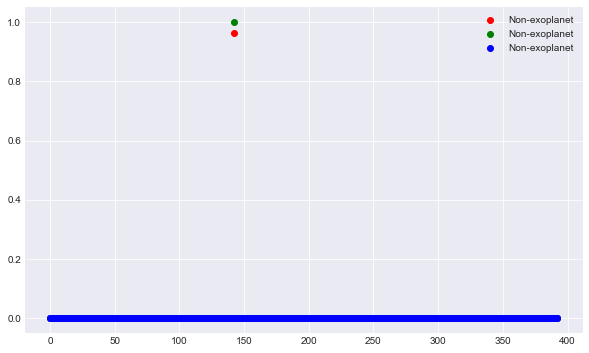

In [36]:
# plots indicating the model allotting different range of scores for different classes
# thus imploying the precision of the model
plt.figure(figsize=(10,6))
plt.plot([y_pred1[i] for i in yes_exoplanet], 'ro', label="Exoplanet")
plt.plot([y_pred2[i] for i in yes_exoplanet], 'go', label="Exoplanet")
plt.plot([y_pred3[i] for i in yes_exoplanet], 'bo', label="Exoplanet")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot([y_pred1[i] for i in no_exoplanet], 'ro', label="Non-exoplanet")
plt.plot([y_pred2[i] for i in no_exoplanet], 'go', label="Non-exoplanet")
plt.plot([y_pred3[i] for i in no_exoplanet], 'bo', label="Non-exoplanet")
plt.legend()
plt.show()

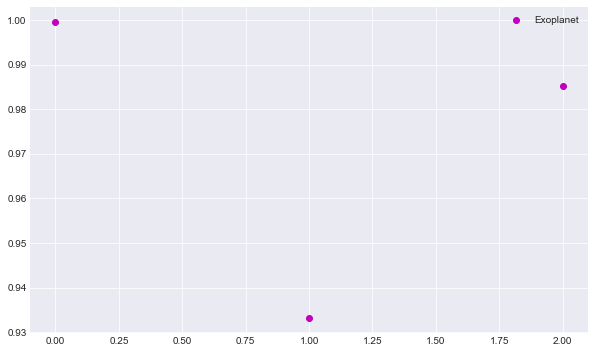

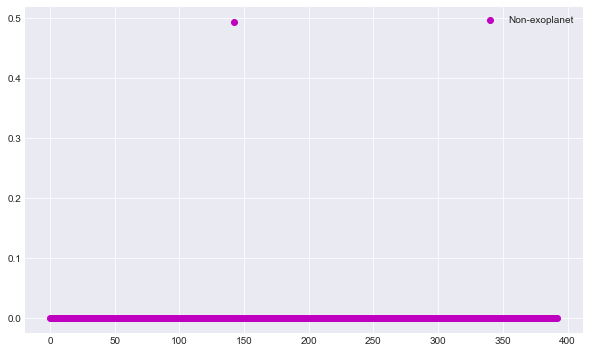

In [37]:
plt.figure(figsize=(10,6))
plt.plot([y_pred4[i] for i in yes_exoplanet], 'mo', label="Exoplanet")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot([y_pred4[i] for i in no_exoplanet], 'mo', label="Non-exoplanet")
plt.legend()
plt.show()

# Model 1 report

F1 score :  0.899364675985
Threshold for F1 score :  0.97
****************************************
True skill score :  0.666666666667
Threshold for True skill score :  0.97


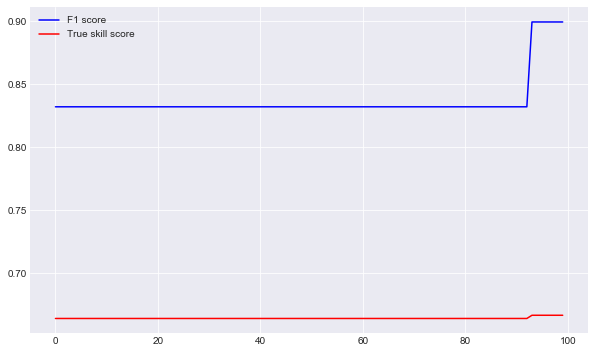

In [38]:
y_true = (y_test[:, 0] + 0.5).astype("int")
f1_score_= []
skill_score_= []

for i in (np.arange(0.5,1.0,.005)):
    y_pred_int= np.copy(y_pred1)
    y_pred_int[(y_pred_int>i)]=1
    y_pred_int[(y_pred_int<=i)]=0

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_int).ravel()

    skill_score_.append(((tp * tn) - (fp * fn)) / ((tp + fn) * (fp + tn)))
    f1_score_.append(f1_score(y_true, y_pred_int, average='macro'))



print("F1 score : ", np.max(f1_score_))
print("Threshold for F1 score : ", (np.min(np.where(f1_score_ == np.max(f1_score_)))+1)*0.005+0.5)
print("*"*40)
print("True skill score : ", np.max(skill_score_))
print("Threshold for True skill score : ", (np.min(np.where(skill_score_ == np.max(skill_score_)))+1)*0.005+0.5)

plt.figure(figsize=(10,6))
plt.plot(f1_score_, color='b', label="F1 score")
plt.plot(skill_score_, color='r', label="True skill score")
plt.legend()
plt.show()

# Model 2 report

F1 score :  0.832061068702
Threshold for F1 score :  0.505
****************************************
True skill score :  0.664122137405
Threshold for True skill score :  0.505


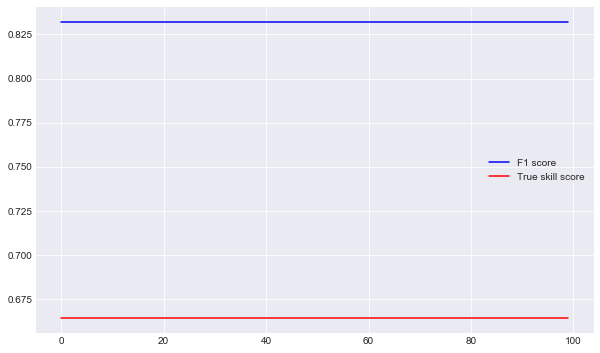

In [39]:
y_true = (y_test[:, 0] + 0.5).astype("int")
f1_score_= []
skill_score_= []

for i in (np.arange(0.5,1.0,.005)):
    y_pred_int= np.copy(y_pred2)
    y_pred_int[(y_pred_int>i)]=1
    y_pred_int[(y_pred_int<=i)]=0

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_int).ravel()

    skill_score_.append(((tp * tn) - (fp * fn)) / ((tp + fn) * (fp + tn)))
    f1_score_.append(f1_score(y_true, y_pred_int, average='macro'))



print("F1 score : ", np.max(f1_score_))
print("Threshold for F1 score : ", (np.min(np.where(f1_score_ == np.max(f1_score_)))+1)*0.005+0.5)
print("*"*40)
print("True skill score : ", np.max(skill_score_))
print("Threshold for True skill score : ", (np.min(np.where(skill_score_ == np.max(skill_score_)))+1)*0.005+0.5)

plt.figure(figsize=(10,6))
plt.plot(f1_score_, color='b', label="F1 score")
plt.plot(skill_score_, color='r', label="True skill score")
plt.legend()
plt.show()

# Model 3 report

F1 score :  0.899364675985
Threshold for F1 score :  0.505
****************************************
True skill score :  0.666666666667
Threshold for True skill score :  0.505


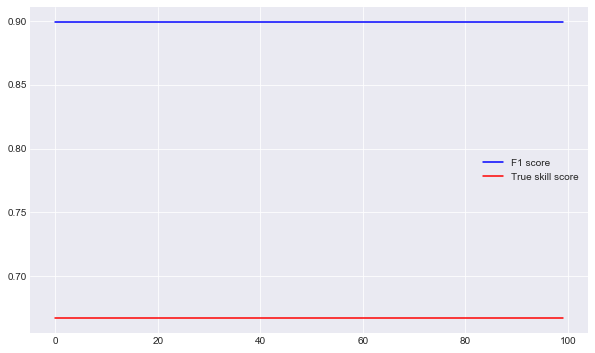

In [40]:
y_true = (y_test[:, 0] + 0.5).astype("int")
f1_score_= []
skill_score_= []

for i in (np.arange(0.5,1.0,.005)):
    y_pred_int= np.copy(y_pred3)
    y_pred_int[(y_pred_int>i)]=1
    y_pred_int[(y_pred_int<=i)]=0

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_int).ravel()

    skill_score_.append(((tp * tn) - (fp * fn)) / ((tp + fn) * (fp + tn)))
    f1_score_.append(f1_score(y_true, y_pred_int, average='macro'))



print("F1 score : ", np.max(f1_score_))
print("Threshold for F1 score : ", (np.min(np.where(f1_score_ == np.max(f1_score_)))+1)*0.005+0.5)
print("*"*40)
print("True skill score : ", np.max(skill_score_))
print("Threshold for True skill score : ", (np.min(np.where(skill_score_ == np.max(skill_score_)))+1)*0.005+0.5)

plt.figure(figsize=(10,6))
plt.plot(f1_score_, color='b', label="F1 score")
plt.plot(skill_score_, color='r', label="True skill score")
plt.legend()
plt.show()

# Model 4 report

F1 score :  1.0
Threshold for F1 score :  0.505
****************************************
True skill score :  1.0
Threshold for True skill score :  0.505


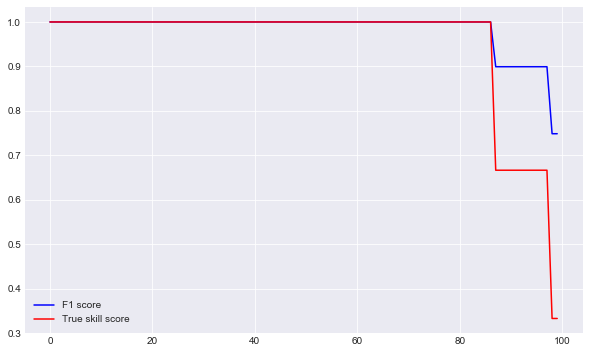

In [41]:
y_true = (y_test[:, 0] + 0.5).astype("int")
f1_score_= []
skill_score_= []

for i in (np.arange(0.5,1.0,.005)):
    y_pred_int= np.copy(y_pred4)
    y_pred_int[(y_pred_int>i)]=1
    y_pred_int[(y_pred_int<=i)]=0

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_int).ravel()

    skill_score_.append(((tp * tn) - (fp * fn)) / ((tp + fn) * (fp + tn)))
    f1_score_.append(f1_score(y_true, y_pred_int, average='macro'))



print("F1 score : ", np.max(f1_score_))
print("Threshold for F1 score : ", (np.min(np.where(f1_score_ == np.max(f1_score_)))+1)*0.005+0.5)
print("*"*40)
print("True skill score : ", np.max(skill_score_))
print("Threshold for True skill score : ", (np.min(np.where(skill_score_ == np.max(skill_score_)))+1)*0.005+0.5)

plt.figure(figsize=(10,6))
plt.plot(f1_score_, color='b', label="F1 score")
plt.plot(skill_score_, color='r', label="True skill score")
plt.legend()
plt.show()

# Evaluation Report

In [42]:
for i in range(len(y_pred1)):
    if y_pred1[i]>0.97: # this value is obtained from the above plot
        y_pred1[i] = 1
    else:
        y_pred1[i] = 0

for i in range(len(y_pred2)):
    if y_pred2[i]>0.505: # this value is obtained from the above plot
        y_pred2[i] = 1
    else:
        y_pred2[i] = 0
        
for i in range(len(y_pred3)):
    if y_pred3[i]>=1: # this value is obtained from the above plot
        y_pred3[i] = 1
    else:
        y_pred3[i] = 0

for i in range(len(y_pred4)):
    if y_pred4[i]>=0.97: # this value is obtained from the above plot
        y_pred4[i] = 1
    else:
        y_pred4[i] = 0        
        

In [43]:
# the precision recall of each class is separately shown hence 
# removing the ambiguity of imbalanced classes..
from sklearn.metrics import classification_report
print("Model 1st report")
print(classification_report(y_true, y_pred1, target_names=['Explanet','Not Explanet']))
print("*"*80)
print("Model 2st report")
print(classification_report(y_true, y_pred2, target_names=['Explanet','Not Explanet']))
print("*"*80)
print("Model 3st report")
print(classification_report(y_true, y_pred3, target_names=['Explanet','Not Explanet']))
print("*"*80)
print("Model 4st report")
print(classification_report(y_true, y_pred4, target_names=['Explanet','Not Explanet']))


Model 1st report
              precision    recall  f1-score   support

    Explanet       1.00      1.00      1.00       393
Not Explanet       1.00      0.67      0.80         3

 avg / total       1.00      1.00      1.00       396

********************************************************************************
Model 2st report
              precision    recall  f1-score   support

    Explanet       1.00      1.00      1.00       393
Not Explanet       0.67      0.67      0.67         3

 avg / total       0.99      0.99      0.99       396

********************************************************************************
Model 3st report
              precision    recall  f1-score   support

    Explanet       0.99      1.00      1.00       393
Not Explanet       0.00      0.00      0.00         3

 avg / total       0.98      0.99      0.99       396

********************************************************************************
Model 4st report
              precision    recal